# Seasonal and subseasonal-to-seasonal predictions of fire frequency and burned area

Author: Jatan Buch (v1, 230619)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Grid scale climate-fire data

### Set up pandas dataframe with data until May 2023

In [11]:
clim_df= init_clim_fire_grid(res= '12km', tscale= 'monthly', start_year= 1952, final_year= 2023, seas_pred_flag= True, pred_mon_ind= 5) #pred_mon_ind --> index of most recent month in calendar year
#clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

100%|██████████| 25/25 [01:22<00:00,  3.30s/it]


### Include oceanic indices: MJO, Nino3.4, MEI

In [36]:
# create a xarray time series object name 'oi_time_series' for all months between 1 Jan 1952 and 1 Mar 2023
oi_time_series = pd.date_range(start='1952-01-01', end='2023-05-01', freq='MS')
oi_time_series = xarray.DataArray(oi_time_series, dims=('time'), coords={'time': oi_time_series})

In [37]:
# create a xarray time series object for all days between 1 Jun 1974 and 31 May 2023
mjo_time_series = pd.date_range(start='1974-06-01', end='2023-05-31', freq='D')
mjo_time_series = xarray.DataArray(mjo_time_series, dims=('time'), coords={'time': mjo_time_series})

rmm1_xarr= xarray.open_dataset('../data/oi_data/mjo_jun23.nc')['RMM1'][:-12] # end date for June data is 12 June 2023
rmm2_xarr= xarray.open_dataset('../data/oi_data/mjo_jun23.nc')['RMM2'][:-12] # end date for May data is 5 May 2023

rmm1_xarr= rmm1_xarr.assign_coords(T= mjo_time_series.time.values)
rmm2_xarr= rmm2_xarr.assign_coords(T= mjo_time_series.time.values)

# coarsen rmm1_xarr and rmm2_xarr to monthly resolution
rmm1_xarr= rmm1_xarr.resample(T= '1MS').mean()
rmm2_xarr= rmm2_xarr.resample(T= '1MS').mean()

# expand rmm1_xarr, rmm2_xarr with NaNs to match the length of oi_time_series
rmm1_xarr= rmm1_xarr.reindex(T= oi_time_series.time.values)
rmm2_xarr= rmm2_xarr.reindex(T= oi_time_series.time.values)

In [38]:
# create a xarray time series object named 'nino_time_series' for all months between 15 Jan 1950 and 15 Apr 2023
nino_time_series = pd.date_range(start='1950-01-01', end='2023-05-01', freq='MS')
nino_time_series = xarray.DataArray(nino_time_series, dims=('time'), coords={'time': nino_time_series})

nino34_arr= np.loadtxt('../data/OI_data/ersst5_nino_may23.txt', skiprows= 1)[:, 8] #xarray.open_dataset('../data/oi_data/nino34_apr23.nc', decode_times= False)['NINO34']
nino34_xarr= xarray.DataArray(nino34_arr, dims=('time'), coords={'time': nino_time_series.time.values})

In [39]:
# read in data from '../data/OI_data/mei_mar23.txt' with columns: year, jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
mei_df= pd.read_csv('../data/oi_data/mei_may23.txt', sep= '\s+', header= None, names= ['year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], skiprows= 1)
mei_df= mei_df.melt(id_vars= ['year'], var_name= 'month', value_name= 'mei')

# convert mei_df to xarray DataArray with time starting from 1 Jan 1950 to 1 Dec 2023
mei_df['time']= pd.to_datetime(mei_df['year'].astype(str) + '-' + mei_df['month'].astype(str))
mei_df= mei_df.drop(columns= ['year', 'month'])
mei_df= mei_df.set_index('time')
mei_df= mei_df.sort_index() # sort mei_df by time
mei_xarr= xarray.DataArray(mei_df['mei'].values, dims=('time'), coords={'time': mei_df.index.values})

# expand mei_xarr with NaNs to match the length of oi_time_series
mei_xarr= mei_xarr.reindex(time= oi_time_series.time.values)

In [18]:
# create a pandas Series for all oi_xarr such that each element is repeated 32240 times (i.e. the number of grid cells in the 12km grid)

mei_series= pd.Series(np.nan_to_num(mei_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
nino34_series= pd.Series(np.nan_to_num(nino34_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
rmm1_series= pd.Series(np.nan_to_num(rmm1_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)
rmm2_series= pd.Series(np.nan_to_num(rmm2_xarr.values, nan= -999)).repeat(32240).reset_index(drop= True)

# add mei_series, nino34_series, rmm1_series, rmm2_series to clim_df
clim_df['mei']= mei_series
clim_df['nino34']= nino34_series
clim_df['rmm1']= rmm1_series
clim_df['rmm2']= rmm2_series

In [19]:
clim_df.to_hdf('../data/clim_12km_1952_2023_data.h5', key= 'df', mode= 'w')

## Subseasonal and S2S forecasts with NGBoost

### De-trending/Grid normalization

In [2]:
clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')

In [3]:
tot_months= len(clim_df.month.unique()) #, 'Solar', 'Tmin', 'Prec', 'RH', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'CAPE'
input_var_arr= ['Tmax', 'Solar', 'VPD', 'Tmin', 'Prec', 'RH', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'CAPE']
trend_flag= False
train_mons= 700

clim_xarr= xarray.Dataset(
            data_vars= dict(
                Tmax= (["time", "Y", "X"], clim_df['Tmax'].values.reshape(tot_months, 208, 155)),
                Solar= (["time", "Y", "X"], clim_df['Solar'].values.reshape(tot_months, 208, 155)),
                VPD= (["time", "Y", "X"], clim_df['VPD'].values.reshape(tot_months, 208, 155)),
                Tmin= (["time", "Y", "X"], clim_df['Tmin'].values.reshape(tot_months, 208, 155)),
                Prec= (["time", "Y", "X"], clim_df['Prec'].values.reshape(tot_months, 208, 155)),
                RH= (["time", "Y", "X"], clim_df['RH'].values.reshape(tot_months, 208, 155)),
                SM_0_100cm= (["time", "Y", "X"], clim_df['SM_0_100cm'].values.reshape(tot_months, 208, 155)),
                PDSI= (["time", "Y", "X"], clim_df['PDSI'].values.reshape(tot_months, 208, 155)),
                FFWI_max7= (["time", "Y", "X"], clim_df['FFWI_max7'].values.reshape(tot_months, 208, 155)),
                CAPE= (["time", "Y", "X"], clim_df['CAPE'].values.reshape(tot_months, 208, 155)),),
            coords=dict(
                X=(["X"], np.linspace(0, 154, 155, dtype= np.int64)),
                Y=(["Y"], np.linspace(0, 207, 208, dtype= np.int64)),
                time= (["time"], np.linspace(0, tot_months - 1, tot_months, dtype= np.int64)),),)

for input_var in input_var_arr:
    time_arr= np.linspace(0, tot_months - 1, tot_months, dtype= np.int64)
    if trend_flag:
        result = clim_xarr[input_var][:train_mons, :, :].polyfit(dim = "time", deg = 1)
        trend= result.polyfit_coefficients.sel(degree= 1).values
        intercept= result.polyfit_coefficients.sel(degree= 0).values

        # multiply trend and intercept with time to get a (857, 208, 155) dimension array
        trend= np.tile(trend, (tot_months, 1, 1))
        intercept= np.tile(intercept, (tot_months, 1, 1))
        trend= np.multiply(trend, time_arr[:, np.newaxis, np.newaxis])
        clim_xarr[input_var + '_trend']= xarray.DataArray(trend + intercept, dims=('time', 'Y', 'X'), coords={'time': clim_xarr.time.values, \
                                                                                                              'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        detrended_arr= clim_xarr[input_var] - clim_xarr[input_var + '_trend']
        clim_xarr[input_var]= xarray.DataArray(detrended_arr/detrended_arr.std(dim= 'time'), dims=('time', 'Y', 'X'), \
                                                                                                   coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(detrended_arr.std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
    else:
        clim_xarr[input_var + '_mean']= xarray.DataArray(np.tile(clim_xarr[input_var][:train_mons, :, :].mean(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var + '_std']= xarray.DataArray(np.tile(clim_xarr[input_var][:train_mons, :, :].std(dim= 'time'), (tot_months, 1, 1)), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})
        clim_xarr[input_var]= xarray.DataArray((clim_xarr[input_var] - clim_xarr[input_var][:train_mons, :, :].mean(dim= 'time'))/clim_xarr[input_var][:train_mons, :, :].std(dim= 'time'), dims=('time', 'Y', 'X'), \
                                                                                    coords={'time': clim_xarr.time.values, 'Y': clim_xarr.Y.values, 'X': clim_xarr.X.values})

input_var_arr= np.append([i for i in clim_xarr.data_vars], ['Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2'])
clim_df= pd.concat([clim_xarr.to_dataframe().reset_index(), clim_df[['Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2']]], axis= 1)

In [4]:
target_arr= np.append(np.append(np.append(np.arange(5, 855, 12), np.arange(5, 855, 12)+1), np.arange(5, 855, 12)+2), np.arange(5, 855, 12)+3)
lead1mons_pred_arr= target_arr - 1
lead2mons_pred_arr= target_arr - 2
lead3mons_pred_arr= target_arr - 3
#lead4mons_pred_arr= target_arr - 4
#lead5mons_pred_arr= target_arr - 5

lead1mons_pred_df= clim_df[clim_df['time'].isin(lead1mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
lead2mons_pred_df= clim_df[clim_df['time'].isin(lead2mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
lead3mons_pred_df= clim_df[clim_df['time'].isin(lead3mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
#lead4mons_pred_df= clim_df[clim_df['time'].isin(lead4mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])
#lead5mons_pred_df= clim_df[clim_df['time'].isin(lead5mons_pred_arr)].dropna()[input_var_arr].reset_index().drop(columns= ['index'])

tmax_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmax'].reset_index().drop(columns= ['index']).rename(columns= {'Tmax': 'Tmax_target'})
prec_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Prec'].reset_index().drop(columns= ['index']).rename(columns= {'Prec': 'Prec_target'})
vpd_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['VPD'].reset_index().drop(columns= ['index']).rename(columns= {'VPD': 'VPD_target'})
ffwi_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['FFWI_max7'].reset_index().drop(columns= ['index']).rename(columns= {'FFWI_max7': 'FFWI_target'})
tmin_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmin'].reset_index().drop(columns= ['index']).rename(columns= {'Tmin': 'Tmin_target'})

lead1mons_df= pd.concat([lead1mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead1mons_df['Elev']= (lead1mons_df['Elev'] - lead1mons_df['Elev'].min())/(lead1mons_df['Elev'].max() - lead1mons_df['Elev'].min())
lead2mons_df= pd.concat([lead2mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
lead3mons_df= pd.concat([lead3mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead4mons_df= pd.concat([lead4mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead5mons_df= pd.concat([lead5mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)

pred_arr_dynamic= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE'], \
                   'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], \
                    'Tmin': ['Tmin', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI']} #'nino34'

#### NGBoost training

In [6]:
pred_var= 'Prec' #'VPD' , 'Tmax', 'FFWI', 'Tmin'
run_id_arr= ['train_grid_normalized_lead1mo', 'train_grid_normalized_lead2mo', 'train_grid_normalized_lead3mo', 'train_grid_normalized_lead4mo', 'train_grid_normalized_lead5mo']

for run_id in tqdm(run_id_arr):
    if run_id == 'train_grid_normalized_lead1mo':
        leadmonsdf= lead1mons_df
        leadsmons_pred_arr= np.sort(lead1mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead2mo':
        leadmonsdf= lead2mons_df
        leadsmons_pred_arr= np.sort(lead2mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead3mo':
        leadmonsdf= lead3mons_df
        leadsmons_pred_arr= np.sort(lead3mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead4mo':
        leadmonsdf= lead4mons_df
        leadsmons_pred_arr= np.sort(lead4mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead5mo':
        leadmonsdf= lead5mons_df
        leadsmons_pred_arr= np.sort(lead5mons_pred_arr)
    
    X= leadmonsdf[input_var_arr][leadmonsdf.time < 700] # train+val:test :: 80:20 #pred_arr_all[pred_var]
    #X_scaled= X[pred_arr_dynamic[pred_var]] - X[pred_arr_trend[pred_var]].values ; X_scaled[pred_arr_dynamic[pred_var]]/X_scaled[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True)
    X_scaled= pd.concat([X[pred_arr_dynamic[pred_var]], X[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
    Y_scaled= leadmonsdf.iloc[X_scaled.index][pred_var + '_target']
    #Y_scaled= Y - leadmonsdf.iloc[X_scaled.index][pred_var + '_trend_target']
    #Y_scaled= Y_scaled/Y_scaled.std()
    X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2)

    poly = PolynomialFeatures(1)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)

    ngb = NGBRegressor(minibatch_frac= 0.1, random_state= 43, n_estimators= 500).fit(X_train_poly, Y_train)
    Y_preds = ngb.predict(X_val_poly)
    Y_dists = ngb.pred_dist(X_val_poly)

    # test Mean Squared Error
    test_MSE = mean_squared_error(Y_preds, Y_val)
    print('Test MSE', test_MSE)

    # test Negative Log Likelihood
    test_NLL = -Y_dists.logpdf(Y_val).mean()
    print('Test NLL', test_NLL)

    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id +'_mb_%.2f.p'%(0.1)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("wb") as f:
        pickle.dump(ngb, f)

  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=1.4802 val_loss=0.0000 scale=1.0000 norm=1.0425
[iter 100] loss=1.3565 val_loss=0.0000 scale=2.0000 norm=1.9303
[iter 200] loss=1.3159 val_loss=0.0000 scale=2.0000 norm=1.9174
[iter 300] loss=1.2920 val_loss=0.0000 scale=1.0000 norm=0.9511
[iter 400] loss=1.2778 val_loss=0.0000 scale=1.0000 norm=0.9477


 20%|██        | 1/5 [27:15<1:49:03, 1635.94s/it]

Test MSE 0.8906024924332745
Test NLL 1.262934418469022
[iter 0] loss=1.4777 val_loss=0.0000 scale=1.0000 norm=1.0399
[iter 100] loss=1.3848 val_loss=0.0000 scale=2.0000 norm=1.9630
[iter 200] loss=1.3455 val_loss=0.0000 scale=1.0000 norm=0.9666
[iter 300] loss=1.3276 val_loss=0.0000 scale=1.0000 norm=0.9628
[iter 400] loss=1.3126 val_loss=0.0000 scale=1.0000 norm=0.9576


 40%|████      | 2/5 [54:19<1:21:26, 1628.82s/it]

Test MSE 0.9244632989300292
Test NLL 1.3016699388788224
[iter 0] loss=1.4789 val_loss=0.0000 scale=1.0000 norm=1.0407
[iter 100] loss=1.3643 val_loss=0.0000 scale=1.0000 norm=0.9649
[iter 200] loss=1.3341 val_loss=0.0000 scale=2.0000 norm=1.9195
[iter 300] loss=1.3158 val_loss=0.0000 scale=1.0000 norm=0.9554
[iter 400] loss=1.3010 val_loss=0.0000 scale=1.0000 norm=0.9512


 60%|██████    | 3/5 [1:21:10<54:01, 1620.65s/it]

Test MSE 0.9037426193595128
Test NLL 1.2905386657516904
[iter 0] loss=1.4789 val_loss=0.0000 scale=1.0000 norm=1.0408
[iter 100] loss=1.3284 val_loss=0.0000 scale=2.0000 norm=1.8793
[iter 200] loss=1.2819 val_loss=0.0000 scale=2.0000 norm=1.8650
[iter 300] loss=1.2593 val_loss=0.0000 scale=1.0000 norm=0.9268
[iter 400] loss=1.2445 val_loss=0.0000 scale=1.0000 norm=0.9237


 80%|████████  | 4/5 [1:48:00<26:56, 1616.19s/it]

Test MSE 0.8256269127307984
Test NLL 1.2305158224267279
[iter 0] loss=1.4789 val_loss=0.0000 scale=1.0000 norm=1.0413
[iter 100] loss=1.3111 val_loss=0.0000 scale=2.0000 norm=1.8650
[iter 200] loss=1.2568 val_loss=0.0000 scale=1.0000 norm=0.9231
[iter 300] loss=1.2389 val_loss=0.0000 scale=1.0000 norm=0.9238
[iter 400] loss=1.2264 val_loss=0.0000 scale=1.0000 norm=0.9217


100%|██████████| 5/5 [2:14:51<00:00, 1618.22s/it]

Test MSE 0.8298963674299251
Test NLL 1.2185462617982836


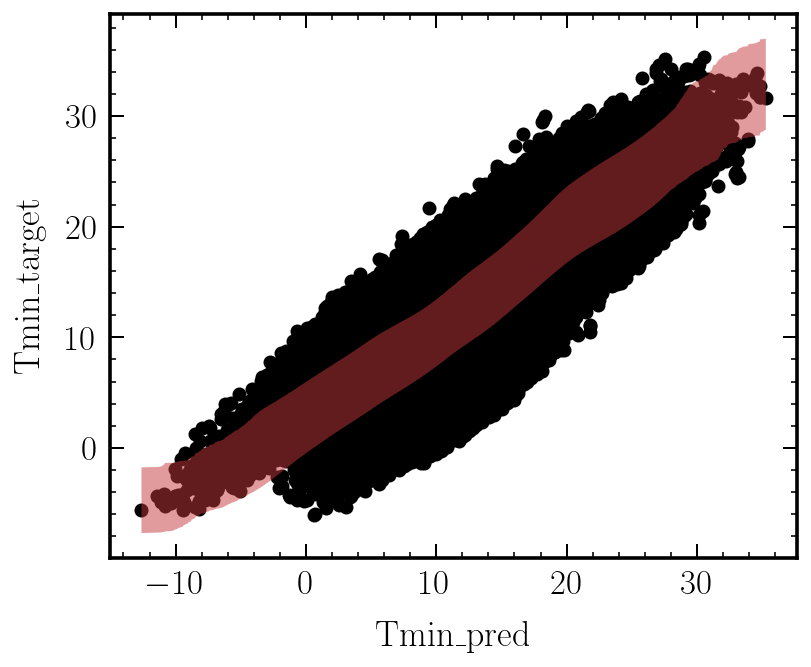

In [8]:
plt.scatter(X_val_poly[:, 1]*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_mean'], Y_val*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_mean'], color= 'black')

Y_pred_low_1sig= (Y_dists.params['loc'] - 1.96 * Y_dists.params['scale'])*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_mean']
Y_pred_high_1sig= (Y_dists.params['loc'] + 1.96 * Y_dists.params['scale'])*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_mean']
plt.fill_between(np.sort(X_val_poly[:, 1]*X.iloc[X_val.index][pred_var + '_std'] + X.iloc[X_val.index][pred_var + '_mean']), np.sort(Y_pred_low_1sig), \
                                                np.sort(Y_pred_high_1sig), alpha= 0.5)
plt.xlabel(r'%s_pred'%pred_var, fontsize= 18)
plt.ylabel(r'%s_target'%pred_var, fontsize= 18)
plt.show()

#### NGBoost predictions

In [7]:
pred_var= 'Prec'  #'VPD', 'Tmax', 'FFWI', 'Tmin'
run_id_arr= ['train_grid_normalized_lead1mo', 'train_grid_normalized_lead2mo', 'train_grid_normalized_lead3mo', 'train_grid_normalized_lead4mo', 'train_grid_normalized_lead5mo']
mb_frac= 0.1

tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc') # for getting the lat/lon coordinates
ind_nan= clim_df.groupby('time').get_group(0).dropna().index
len_xcoord= len(tmax_xr.X)
len_ycoord= len(tmax_xr.Y)

for run_id in tqdm(run_id_arr):
    if run_id == 'train_grid_normalized_lead1mo':
        leadmonsdf= lead1mons_df
        leadsmons_pred_arr= np.sort(lead1mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead2mo':
        leadmonsdf= lead2mons_df
        leadsmons_pred_arr= np.sort(lead2mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead3mo':
        leadmonsdf= lead3mons_df
        leadsmons_pred_arr= np.sort(lead3mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead4mo':
        leadmonsdf= lead4mons_df
        leadsmons_pred_arr= np.sort(lead4mons_pred_arr)
    elif run_id == 'train_grid_normalized_lead5mo':
        leadmonsdf= lead5mons_df
        leadsmons_pred_arr= np.sort(lead5mons_pred_arr)
    
    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("rb") as f:
        ngb= pickle.load(f)

    Y_dist_loc= []
    Y_dist_scale= []
    # Y_obs= []

    leadmonsdf_groups= leadmonsdf.groupby(['time'], as_index= False)
    for m in leadsmons_pred_arr:
        X_test= leadmonsdf_groups.get_group(m)[input_var_arr]
        if pred_var == 'FFWI':
            Y_test_std= leadmonsdf_groups.get_group(m)['FFWI_max7_std'] # ensure that Y is always the target variable and not a predictor
            Y_test_mean= leadmonsdf_groups.get_group(m)['FFWI_max7_mean']
        else:
            Y_test_std= leadmonsdf_groups.get_group(m)[pred_var + '_std'] # ensure that Y is always the target variable and not a predictor
            Y_test_mean= leadmonsdf_groups.get_group(m)[pred_var + '_mean']

        X_test_scaled= pd.concat([X_test[pred_arr_dynamic[pred_var]], X_test[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
        poly = PolynomialFeatures(1)
        X_test_poly= poly.fit_transform(X_test_scaled)
        
        tmplocarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmpsigarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmplocarr[ind_nan]= ngb.pred_dist(X_test_poly).params['loc']*Y_test_std + Y_test_mean
        tmpsigarr[ind_nan]= ngb.pred_dist(X_test_poly).params['scale']*Y_test_std
        Y_dist_loc.append(tmplocarr)
        Y_dist_scale.append(tmpsigarr)

        # tmpobsarr= np.ones(len_xcoord*len_ycoord)*np.nan
        # tmpobsarr[ind_nan]= leadmonsdf_groups.get_group(m)[pred_var + '_target']
        # Y_obs.append(tmpobsarr)
        
    # convert Y_dist_loc and Y_dist_scale to xarray with X and Y dimensions equal to len_ycoord and len_xcoord
    Y_dist_loc_xr= xarray.DataArray(np.array(Y_dist_loc).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                            coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    Y_dist_scale_xr= xarray.DataArray(np.array(Y_dist_scale).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                            coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    Y_dist_loc_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
    Y_dist_scale_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
    
    #Y_obs_xr= xarray.DataArray(np.array(Y_obs).reshape(len(target_arr), len_ycoord, len_xcoord), \
    #                                        coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    #Y_obs_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_obs.nc')

100%|██████████| 5/5 [28:24<00:00, 340.82s/it]


### Overall normalized scaling

In [2]:
clim_df= pd.read_hdf('../data/clim_12km_1952_2023_data.h5')
clim_df['time']= clim_df['month']
clim_df.drop(columns= ['month'], inplace= True)

# Group clim_df by X and Y to get a list of all non-nan grid cells
# clim_df_groups= clim_df.dropna().groupby(['X', 'Y'], as_index= False)
# clim_df_group_keys= clim_df_groups.groups.keys()

In [3]:
target_arr= np.append(np.append(np.append(np.arange(5, 855, 12), np.arange(5, 855, 12)+1), np.arange(5, 855, 12)+2), np.arange(5, 855, 12)+3)
lead1mons_pred_arr= target_arr - 1
lead2mons_pred_arr= target_arr - 2
lead3mons_pred_arr= target_arr - 3

lead1mons_pred_df= clim_df[clim_df['time'].isin(lead1mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])
lead2mons_pred_df= clim_df[clim_df['time'].isin(lead2mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])
lead3mons_pred_df= clim_df[clim_df['time'].isin(lead3mons_pred_arr)].dropna()[['Tmax', 'VPD', 'Prec', 'Solar', 'RH', 'CAPE', 'Tmin', 'SM_0_100cm', 'PDSI', 'FFWI_max7', 'Southness', 'Elev', 'time', 'X', 'Y', 'mei', 'nino34', 'rmm1', 'rmm2']].reset_index().drop(columns= ['index'])

tmax_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmax'].reset_index().drop(columns= ['index']).rename(columns= {'Tmax': 'Tmax_target'})
prec_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Prec'].reset_index().drop(columns= ['index']).rename(columns= {'Prec': 'Prec_target'})
vpd_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['VPD'].reset_index().drop(columns= ['index']).rename(columns= {'VPD': 'VPD_target'})
ffwi_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['FFWI_max7'].reset_index().drop(columns= ['index']).rename(columns= {'FFWI_max7': 'FFWI_target'})
tmin_target_df= clim_df[clim_df['time'].isin(target_arr)].dropna()['Tmin'].reset_index().drop(columns= ['index']).rename(columns= {'Tmin': 'Tmin_target'})

lead1mons_df= pd.concat([lead1mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead1mons_df['Elev']= (lead1mons_df['Elev'] - lead1mons_df['Elev'].min())/(lead1mons_df['Elev'].max() - lead1mons_df['Elev'].min())
lead2mons_df= pd.concat([lead2mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead2mons_df['Elev']= (lead2mons_df['Elev'] - lead2mons_df['Elev'].min())/(lead2mons_df['Elev'].max() - lead2mons_df['Elev'].min())
lead3mons_df= pd.concat([lead3mons_pred_df, tmax_target_df, prec_target_df, vpd_target_df, tmin_target_df, ffwi_target_df], axis= 1).replace(-999, np.nan)
#lead3mons_df['Elev']= (lead3mons_df['Elev'] - lead3mons_df['Elev'].min())/(lead3mons_df['Elev'].max() - lead3mons_df['Elev'].min())

In [4]:
pred_arr_all= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI' , 'Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2'], \
               'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2'], \
               'Tmin': ['Tmin', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'Southness', 'Elev', 'mei', 'nino34', 'rmm1', 'rmm2']}
pred_arr_dynamic= {'Tmax': ['Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'Prec': ['Prec', 'Tmax', 'Solar', 'RH', 'SM_0_100cm', 'PDSI', 'CAPE'], \
                   'VPD': ['VPD', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], 'FFWI': ['FFWI_max7', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI'], \
                    'Tmin': ['Tmin', 'Tmax', 'Prec', 'Solar', 'RH', 'SM_0_100cm', 'PDSI']} #'nino34'

#### NGBoost training

In [6]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'FFWI', 'Tmin'] 
run_id= 'normalized_lead3mo'
if run_id == 'normalized_lead1mo':
    leadmonsdf= lead1mons_df
    leadsmons_pred_arr= np.sort(lead1mons_pred_arr)
elif run_id == 'normalized_lead2mo':
    leadmonsdf= lead2mons_df
    leadsmons_pred_arr= np.sort(lead2mons_pred_arr)
elif run_id == 'normalized_lead3mo':
    leadmonsdf= lead3mons_df
    leadsmons_pred_arr= np.sort(lead3mons_pred_arr)

for pred_var in tqdm(pred_var_arr):
    X= leadmonsdf[pred_arr_all[pred_var]][leadmonsdf.time < 700] # train+val:test :: 80:20
    #X_scaled= X - X.mean(axis= 0, skipna= True)/X.std(axis= 0, skipna= True)
    X_scaled= pd.concat([(X[pred_arr_dynamic[pred_var]] - X[pred_arr_dynamic[pred_var]].mean(axis= 0, skipna= True))/X[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True), \
                                            X[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
    Y= leadmonsdf.iloc[X_scaled.index][pred_var + '_target']
    Y_scaled= (Y - Y.mean())/Y.std()
    X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_scaled, test_size=0.2)

    poly = PolynomialFeatures(1)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)

    ngb = NGBRegressor(minibatch_frac= 0.1, random_state= 42).fit(X_train_poly, Y_train)
    Y_preds = ngb.predict(X_val_poly)
    Y_dists = ngb.pred_dist(X_val_poly)

    # test Mean Squared Error
    test_MSE = mean_squared_error(Y_preds, Y_val)
    print('Test MSE', test_MSE)

    # test Negative Log Likelihood
    test_NLL = -Y_dists.logpdf(Y_val).mean()
    print('Test NLL', test_NLL)

    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id +'_mb_%.2f.p'%(0.1)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("wb") as f:
        pickle.dump(ngb, f)

  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=1.4216 val_loss=0.0000 scale=1.0000 norm=1.0017
[iter 100] loss=1.1221 val_loss=0.0000 scale=2.0000 norm=1.5488
[iter 200] loss=0.9487 val_loss=0.0000 scale=1.0000 norm=0.7052
[iter 300] loss=0.8443 val_loss=0.0000 scale=1.0000 norm=0.6890
[iter 400] loss=0.7971 val_loss=0.0000 scale=1.0000 norm=0.6856


 20%|██        | 1/5 [19:08<1:16:32, 1148.16s/it]

Test MSE 0.31194589932254563
Test NLL 0.7662181422981377
[iter 0] loss=1.4274 val_loss=0.0000 scale=1.0000 norm=1.0067
[iter 100] loss=1.3276 val_loss=0.0000 scale=2.0000 norm=1.8695
[iter 200] loss=1.2832 val_loss=0.0000 scale=1.0000 norm=0.9208
[iter 300] loss=1.2631 val_loss=0.0000 scale=1.0000 norm=0.9157
[iter 400] loss=1.2501 val_loss=0.0000 scale=1.0000 norm=0.9134


 40%|████      | 2/5 [40:50<1:01:56, 1238.98s/it]

Test MSE 0.8038429940253712
Test NLL 1.2334614396664438
[iter 0] loss=1.4209 val_loss=0.0000 scale=1.0000 norm=1.0007
[iter 100] loss=1.0710 val_loss=0.0000 scale=1.0000 norm=0.7451
[iter 200] loss=0.9225 val_loss=0.0000 scale=1.0000 norm=0.6961
[iter 300] loss=0.8475 val_loss=0.0000 scale=1.0000 norm=0.6890
[iter 400] loss=0.8052 val_loss=0.0000 scale=1.0000 norm=0.6897


 60%|██████    | 3/5 [1:03:06<42:46, 1283.09s/it]

Test MSE 0.32620671918017957
Test NLL 0.7756398831333686
[iter 0] loss=1.4224 val_loss=0.0000 scale=1.0000 norm=1.0024
[iter 100] loss=1.1598 val_loss=0.0000 scale=1.0000 norm=0.8051
[iter 200] loss=1.0298 val_loss=0.0000 scale=2.0000 norm=1.5540
[iter 300] loss=0.9963 val_loss=0.0000 scale=1.0000 norm=0.7767
[iter 400] loss=0.9779 val_loss=0.0000 scale=1.0000 norm=0.7749


 80%|████████  | 4/5 [1:25:24<21:44, 1304.92s/it]

Test MSE 0.46743999391838104
Test NLL 0.964796314799495
[iter 0] loss=1.4201 val_loss=0.0000 scale=1.0000 norm=1.0001
[iter 100] loss=1.1076 val_loss=0.0000 scale=1.0000 norm=0.7697
[iter 200] loss=0.9587 val_loss=0.0000 scale=1.0000 norm=0.7132
[iter 300] loss=0.8738 val_loss=0.0000 scale=1.0000 norm=0.6981
[iter 400] loss=0.8313 val_loss=0.0000 scale=1.0000 norm=0.6969


100%|██████████| 5/5 [1:47:46<00:00, 1293.28s/it]

Test MSE 0.33135431003356447
Test NLL 0.8006579498819475


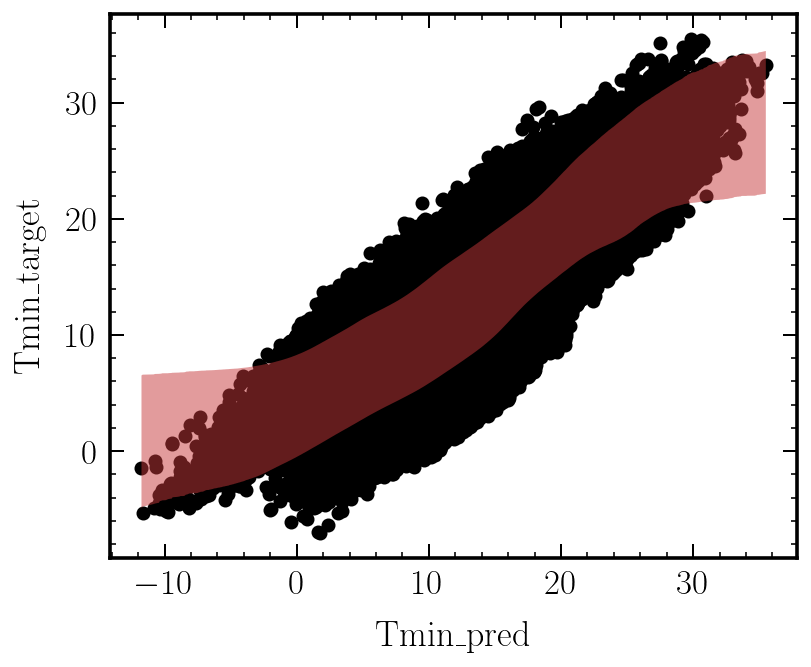

In [9]:
plt.scatter(X_val_poly[:, 1]*X[pred_var].std(axis= 0, skipna= True) + X[pred_var].mean(axis= 0, skipna= True), Y_val*Y.std() + Y.mean(), color= 'black')

Y_pred_low_1sig= (Y_dists.params['loc'] - 1.96 * Y_dists.params['scale'])*Y.std() + Y.mean()
Y_pred_high_1sig= (Y_dists.params['loc'] + 1.96 * Y_dists.params['scale'])*Y.std() + Y.mean()
plt.fill_between(np.sort(X_val_poly[:, 1]*X[pred_var].std(axis= 0, skipna= True) + X[pred_var].mean(axis= 0, skipna= True)), np.sort(Y_pred_low_1sig), \
                                                np.sort(Y_pred_high_1sig), alpha= 0.5)
plt.xlabel(r'%s_pred'%pred_var, fontsize= 18)
plt.ylabel(r'%s_target'%pred_var, fontsize= 18)
plt.show()

#### NGBoost predictions 

In [8]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'FFWI', 'Tmin']
run_id= 'normalized_lead3mo'
mb_frac= 0.1

tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc') # for getting the lat/lon coordinates
ind_nan= clim_df.groupby('time').get_group(0).dropna().index
len_xcoord= len(tmax_xr.X)
len_ycoord= len(tmax_xr.Y)

for pred_var in tqdm(pred_var_arr):
    ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
    file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
    with file_path.open("rb") as f:
        ngb= pickle.load(f)

    pred_list= deepcopy(pred_arr_all[pred_var])
    pred_list.extend(['time', 'X', 'Y'])

    X= leadmonsdf[pred_list][leadmonsdf.time < 700]
    Y= leadmonsdf.iloc[X.index][pred_var + '_target'] # ensure that Y is always the target variable and not a predictor

    Y_dist_loc= []
    Y_dist_scale= []
    Y_obs= []

    leadmonsdf_groups= leadmonsdf.groupby(['time'], as_index= False)
    for m in leadsmons_pred_arr:
        X_test= leadmonsdf_groups.get_group(m)[pred_list]
        #X_test_scaled= X_test - X.mean(axis= 0, skipna= True)/X.std(axis= 0, skipna= True)
        X_test_scaled= pd.concat([(X_test[pred_arr_dynamic[pred_var]] - X[pred_arr_dynamic[pred_var]].mean(axis= 0, skipna= True))/X[pred_arr_dynamic[pred_var]].std(axis= 0, skipna= True), \
                                                X_test[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
        poly = PolynomialFeatures(1)
        X_test_poly= poly.fit_transform(X_test_scaled)
        
        tmplocarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmpsigarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmpobsarr= np.ones(len_xcoord*len_ycoord)*np.nan
        tmplocarr[ind_nan]= ngb.pred_dist(X_test_poly).params['loc']*Y.std() + Y.mean()
        tmpsigarr[ind_nan]= ngb.pred_dist(X_test_poly).params['scale']*Y.std()
        tmpobsarr[ind_nan]= leadmonsdf_groups.get_group(m)[pred_var + '_target']

        Y_dist_loc.append(tmplocarr)
        Y_dist_scale.append(tmpsigarr)
        Y_obs.append(tmpobsarr)

    # convert Y_dist_loc and Y_dist_scale to xarray with X and Y dimensions equal to len_ycoord and len_xcoord
    Y_dist_loc_xr= xarray.DataArray(np.array(Y_dist_loc).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                            coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    Y_dist_scale_xr= xarray.DataArray(np.array(Y_dist_scale).reshape(len(target_arr), len_ycoord, len_xcoord), \
                                            coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])
    #Y_obs_xr= xarray.DataArray(np.array(Y_obs).reshape(len(target_arr), len_ycoord, len_xcoord), \
    #                                        coords= {'time': np.sort(target_arr), 'Y': tmax_xr.Y, 'X': tmax_xr.X}, dims= ['time', 'Y', 'X'])

    Y_dist_loc_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
    Y_dist_scale_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
    #Y_obs_xr.to_netcdf('../sav_files/ngb_pred_files/%s'%pred_var + '_obs.nc')

100%|██████████| 5/5 [37:35<00:00, 451.17s/it]


### NGBoost plotting 

In [8]:
pred_var= 'Prec'
unit_arr= {'Tmax': 'degC', 'Prec': 'mm' ,'VPD': 'hPa', 'FFWI': 'Intensity', 'Tmin': 'degC'}
mb_frac= 0.1
run_id= 'train_grid_normalized_lead1mo'

Y_dist_loc_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
Y_dist_scale_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
Y_obs_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_obs.nc')

In [9]:
#run_id_arr= ['train_grid_normalized_lead1mo', 'train_grid_normalized_lead2mo', 'train_grid_normalized_lead3mo', 'train_grid_normalized_lead4mo', 'train_grid_normalized_lead5mo']
pearson_test_r_arr= []

for run_id in run_id_arr:
    Y_pred_xr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
    pearson_test_r_arr.append(stats.pearsonr(np.mean(Y_pred_xr[232:, :, :], axis= (1,2)), np.mean(Y_obs_xr[232:, :, :], axis= (1,2)))[0])

In [10]:
pearson_test_r_arr

[0.26682819835250116,
 -0.0413228253505682,
 0.053259839811266016,
 -0.02168443356486427,
 -0.01456628087292583]

In [11]:
grid_all= np.where(~np.isnan(Y_dist_loc_xr[0, :, :])) # choose random non nan grid cell for plotting
pearson_r_arr= [stats.pearsonr(Y_dist_loc_xr[:, grid_all[0][g], grid_all[1][g]], Y_obs_xr[:, grid_all[0][g], grid_all[1][g]])[0] for g in tqdm(range(len(grid_all[0])))]

best_ind_arr= np.argsort(pearson_r_arr)[-3:]
worst_ind_arr= np.argsort(pearson_r_arr)[:3]
rand_ind_arr= np.random.randint(0, len(grid_all[0]), 3)

100%|██████████| 23903/23903 [01:12<00:00, 330.97it/s]


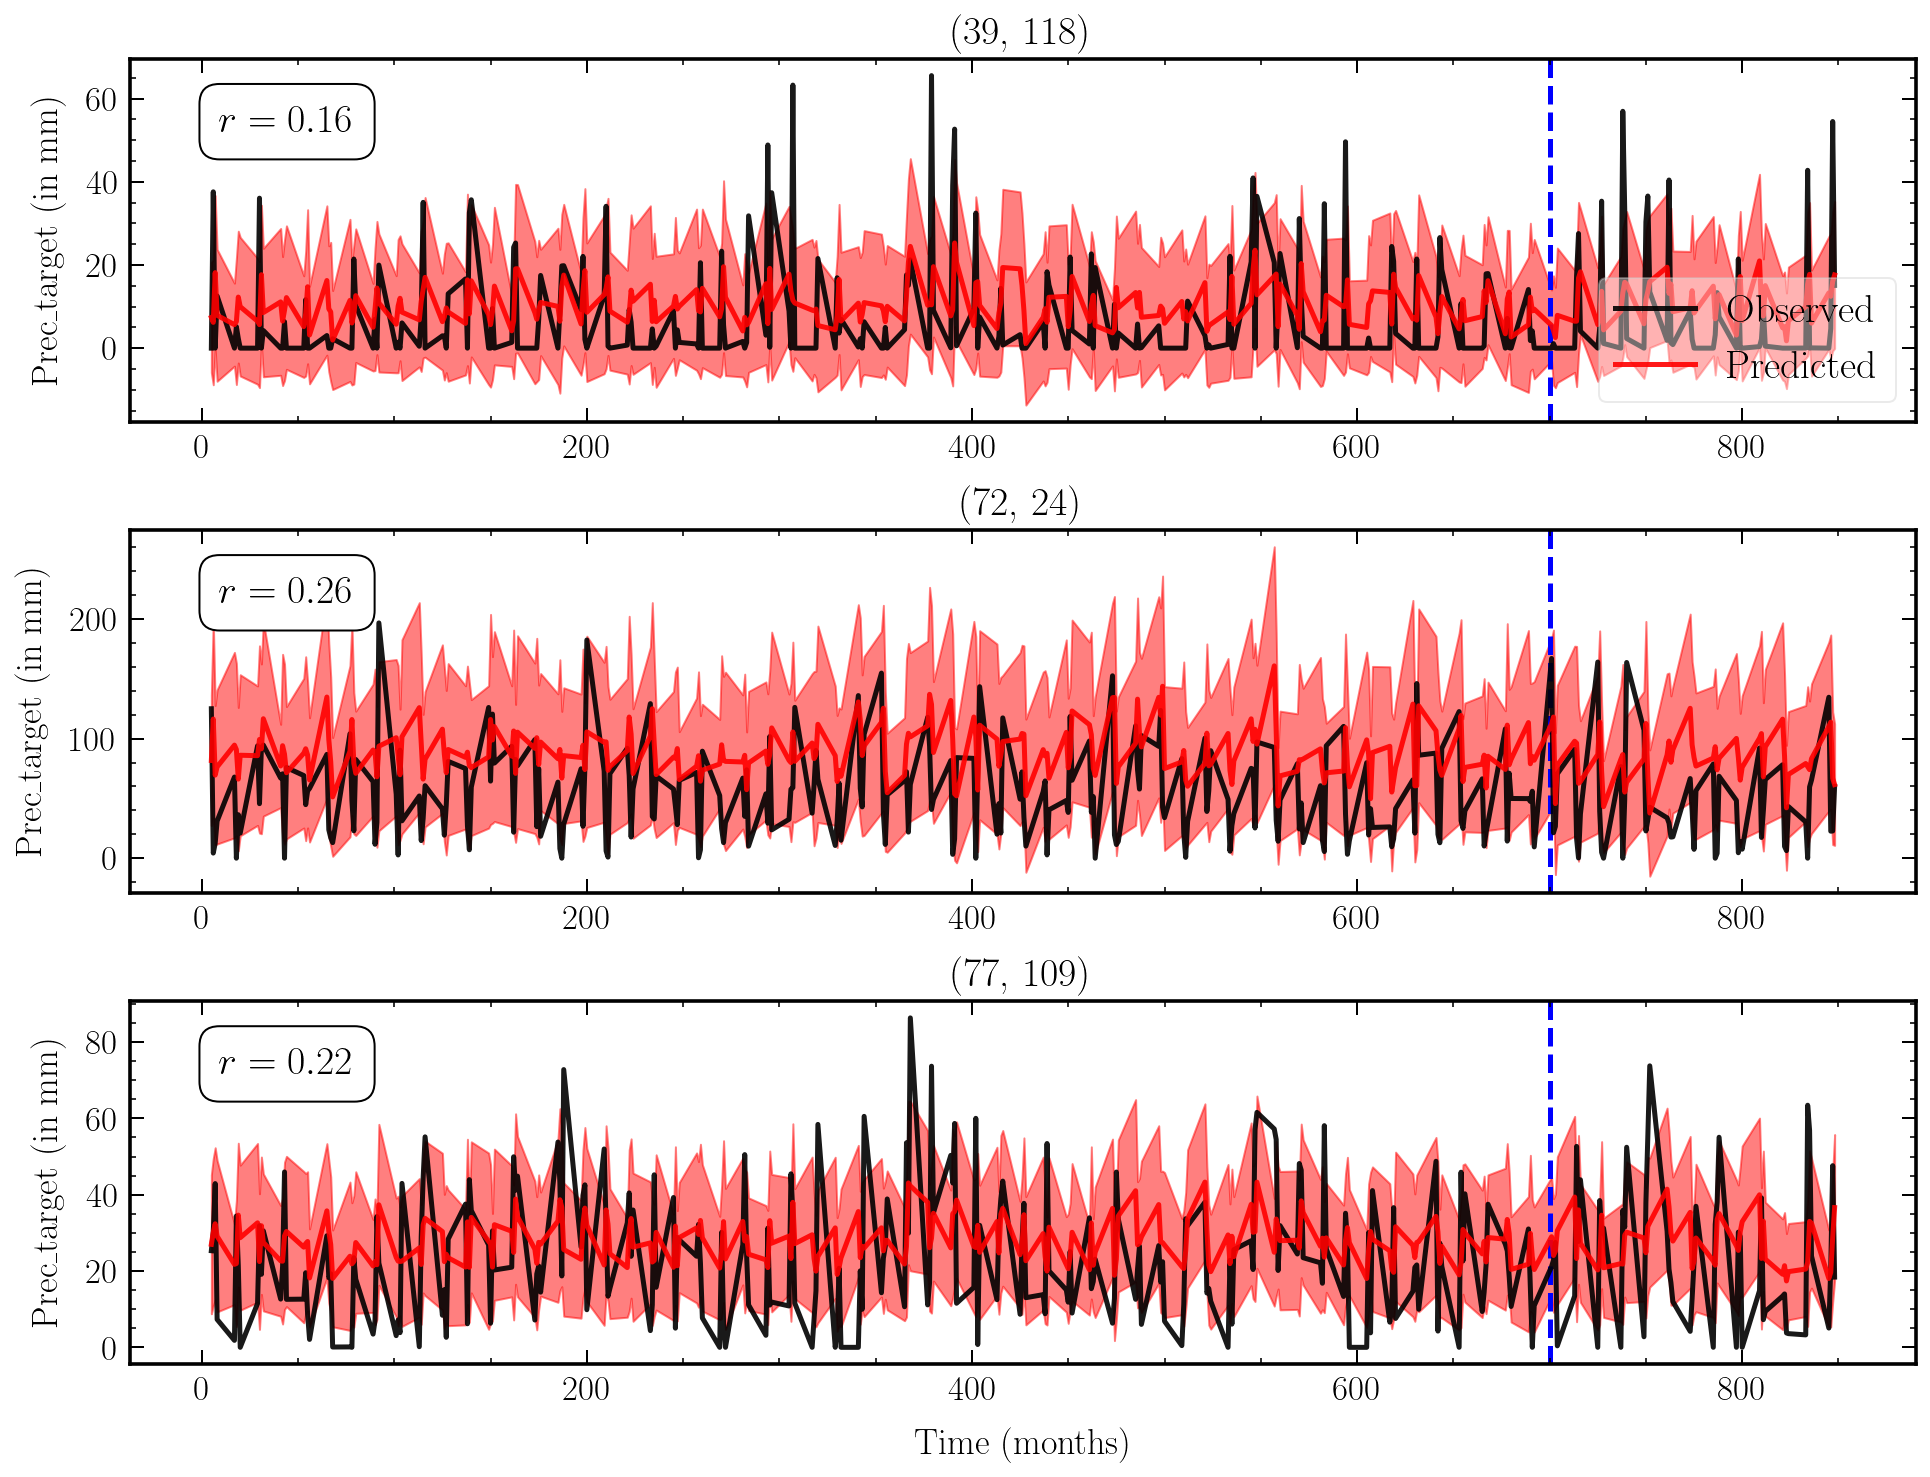

In [12]:
fig, ax= plt.subplots(3, 1, figsize=(16, 12))
config= 'random'

if config == 'best':
    ind_y_arr= grid_all[0][best_ind_arr]
    ind_x_arr= grid_all[1][best_ind_arr]
elif config == 'worst':
    ind_y_arr= grid_all[0][worst_ind_arr]
    ind_x_arr= grid_all[1][worst_ind_arr]
elif config == 'random':
    ind_y_arr= grid_all[0][rand_ind_arr]
    ind_x_arr= grid_all[1][rand_ind_arr]

for i in range(3):
    pearson_r= stats.pearsonr(Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]], Y_obs_xr[:, ind_y_arr[i], ind_x_arr[i]])[0]
    Y_pred_low_1sig= Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]] - Y_dist_scale_xr[:, ind_y_arr[i], ind_x_arr[i]]
    Y_pred_high_1sig= Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]] + Y_dist_scale_xr[:, ind_y_arr[i], ind_x_arr[i]]

    ax[i].plot(Y_obs_xr.time, Y_obs_xr[:, ind_y_arr[i], ind_x_arr[i]], color= 'black', label= 'Observed')
    ax[i].plot(Y_obs_xr.time, Y_dist_loc_xr[:, ind_y_arr[i], ind_x_arr[i]], color= 'red', label= 'Predicted')
    ax[i].fill_between(Y_obs_xr.time, Y_pred_low_1sig, Y_pred_high_1sig, color= 'red', alpha= 0.5)

    if i== 2:
        ax[i].set_xlabel(r'Time (months)', fontsize= 18);
    ax[i].set_ylabel(pred_var + '_target ' + '(in %s)'%(unit_arr[pred_var]), fontsize= 18);
    ax[i].text(0.05, 0.8, r'$r = %.2f$'%pearson_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
            transform=ax[i].transAxes)
    #ax[i].set_ylim(10, 40);
    if i== 0:
        ax[i].legend(loc='lower right', frameon= True, fontsize= 20);
    ax[i].set_title(r'(%d, '%ind_x_arr[i] + '%d)'%ind_y_arr[i], fontsize= 20);
    fig.subplots_adjust(hspace= 0.3)
    ax[i].axvline(x= 700, color= 'blue', lw= 2.5, linestyle= '--', zorder= 1)
    #plt.savefig('../plots/%s'%pred_var + '_ngboost_%s'%config + '_prediction_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

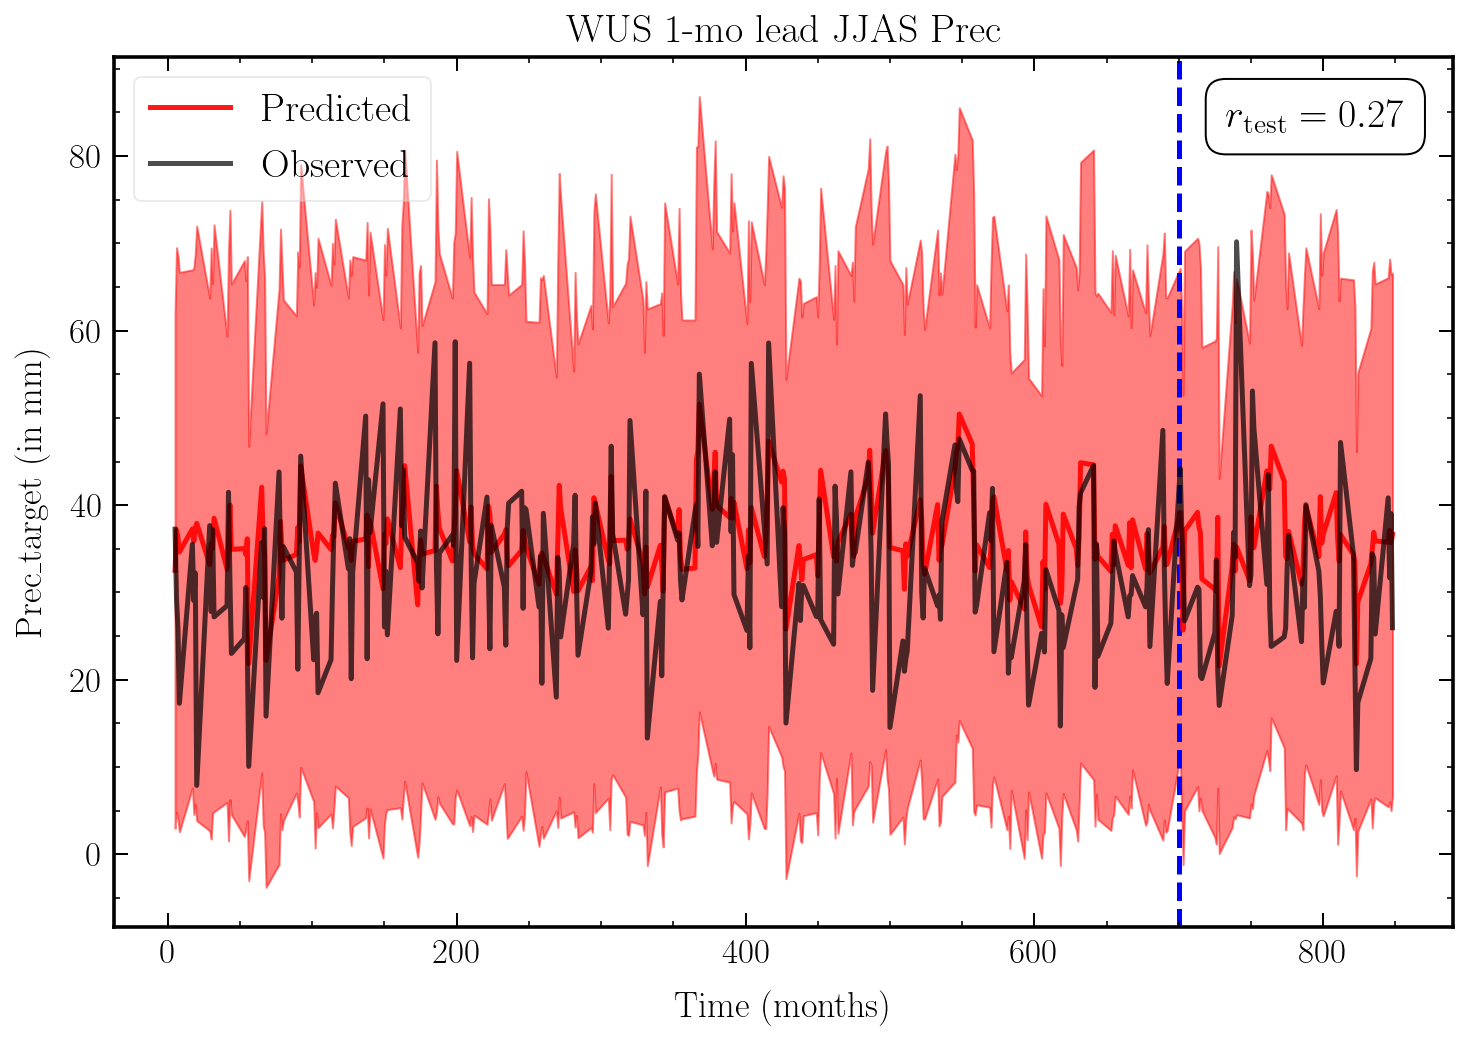

In [13]:
fig, ax= plt.subplots(1, 1, figsize=(12, 8))

plt.plot(Y_dist_loc_xr.time, np.mean(Y_dist_loc_xr, axis= (1,2)), color= 'red', label= 'Predicted')
plt.fill_between(Y_dist_loc_xr.time, np.mean(Y_dist_loc_xr, axis= (1,2)) - np.mean(Y_dist_scale_xr, axis= (1,2)), \
                                                np.mean(Y_dist_loc_xr, axis= (1,2)) + np.mean(Y_dist_scale_xr, axis= (1,2)), color= 'red', alpha= 0.5)
plt.plot(Y_dist_loc_xr.time, np.mean(Y_obs_xr, axis= (1,2)), color= 'black', label= 'Observed', alpha= 0.7)

pearson_train_r= stats.pearsonr(np.mean(Y_dist_loc_xr[:232, :, :], axis= (1,2)), np.mean(Y_obs_xr[:232, :, :], axis= (1,2)))[0]
pearson_test_r= stats.pearsonr(np.mean(Y_dist_loc_xr[232:, :, :], axis= (1,2)), np.mean(Y_obs_xr[232:, :, :], axis= (1,2)))[0]

ax.set_xlabel(r'Time (months)', fontsize= 18);
ax.set_ylabel(pred_var + '_target ' + '(in %s)'%(unit_arr[pred_var]), fontsize= 18);
ax.text(0.83, 0.92, r'$r_{\rm test} = %.2f$'%pearson_test_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
        transform=ax.transAxes)
#ax.text(0.83, 0.92, r'$r_{\rm test} = %.2f$'%pearson_test_r, fontsize= 20, bbox=dict(boxstyle='round, pad=0.5', ec= 'black', fc= 'white'), \
#        transform=ax.transAxes)
ax.legend(loc='upper left', frameon= True, fontsize= 20);
ax.set_title(r'WUS 1-mo lead JJAS %s'%pred_var, fontsize= 20);
ax.axvline(x= 700, color= 'blue', lw= 2.5, linestyle= '--', zorder= 1)
plt.savefig('../plots/%s'%pred_var + '_ngboost_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

In [14]:
lat_long_fire_grid= coord_transform(Y_dist_loc_xr['X'][:].data, Y_dist_loc_xr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')
jun_arr= np.arange(5, 855, 12)
jul_arr= jun_arr + 1
aug_arr= jun_arr + 2
sep_arr= jun_arr + 3

jun_jul_baseline= np.append(jun_arr[0:57], jul_arr[0:57]) #1952 -- 2010: [0:57]; 2000 -- 2020: [48:69]
aug_sep_baseline= np.append(aug_arr[0:57], sep_arr[0:57])
jun_jul_test= np.append(jun_arr[65:], jul_arr[65:])
aug_sep_test= np.append(aug_arr[65:], sep_arr[65:])

In [15]:
pred_anom_jj_xarr= Y_dist_loc_xr[Y_dist_loc_xr.time.isin(jun_jul_test), :, :] - np.mean(Y_dist_loc_xr[Y_dist_loc_xr.time.isin(jun_jul_baseline), :, :], axis= 0)
obs_anom_jj_xarr= Y_obs_xr[Y_obs_xr.time.isin(jun_jul_test), :, :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(jun_jul_baseline), :, :], axis= 0)
pred_anom_as_xarr= Y_dist_loc_xr[Y_dist_loc_xr.time.isin(aug_sep_test), :, :] - np.mean(Y_dist_loc_xr[Y_dist_loc_xr.time.isin(aug_sep_baseline), :, :], axis= 0)
obs_anom_as_xarr= Y_obs_xr[Y_obs_xr.time.isin(aug_sep_test), :, :] - np.mean(Y_obs_xr[Y_obs_xr.time.isin(aug_sep_baseline), :, :], axis= 0)


# calculate cosine similarity between predicted and observed anomalies
cos_sim_jj_xarr= xarray.dot(pred_anom_jj_xarr, obs_anom_jj_xarr, dims= ['time'])/(np.sqrt(xarray.dot(pred_anom_jj_xarr, pred_anom_jj_xarr, dims= ['time'])) * \
                                                                                                            np.sqrt(xarray.dot(obs_anom_jj_xarr, obs_anom_jj_xarr, dims= ['time'])))
cos_sim_as_xarr= xarray.dot(pred_anom_as_xarr, obs_anom_as_xarr, dims= ['time'])/(np.sqrt(xarray.dot(pred_anom_as_xarr, pred_anom_as_xarr, dims= ['time'])) * \
                                                                                                            np.sqrt(xarray.dot(obs_anom_as_xarr, obs_anom_as_xarr, dims= ['time'])))

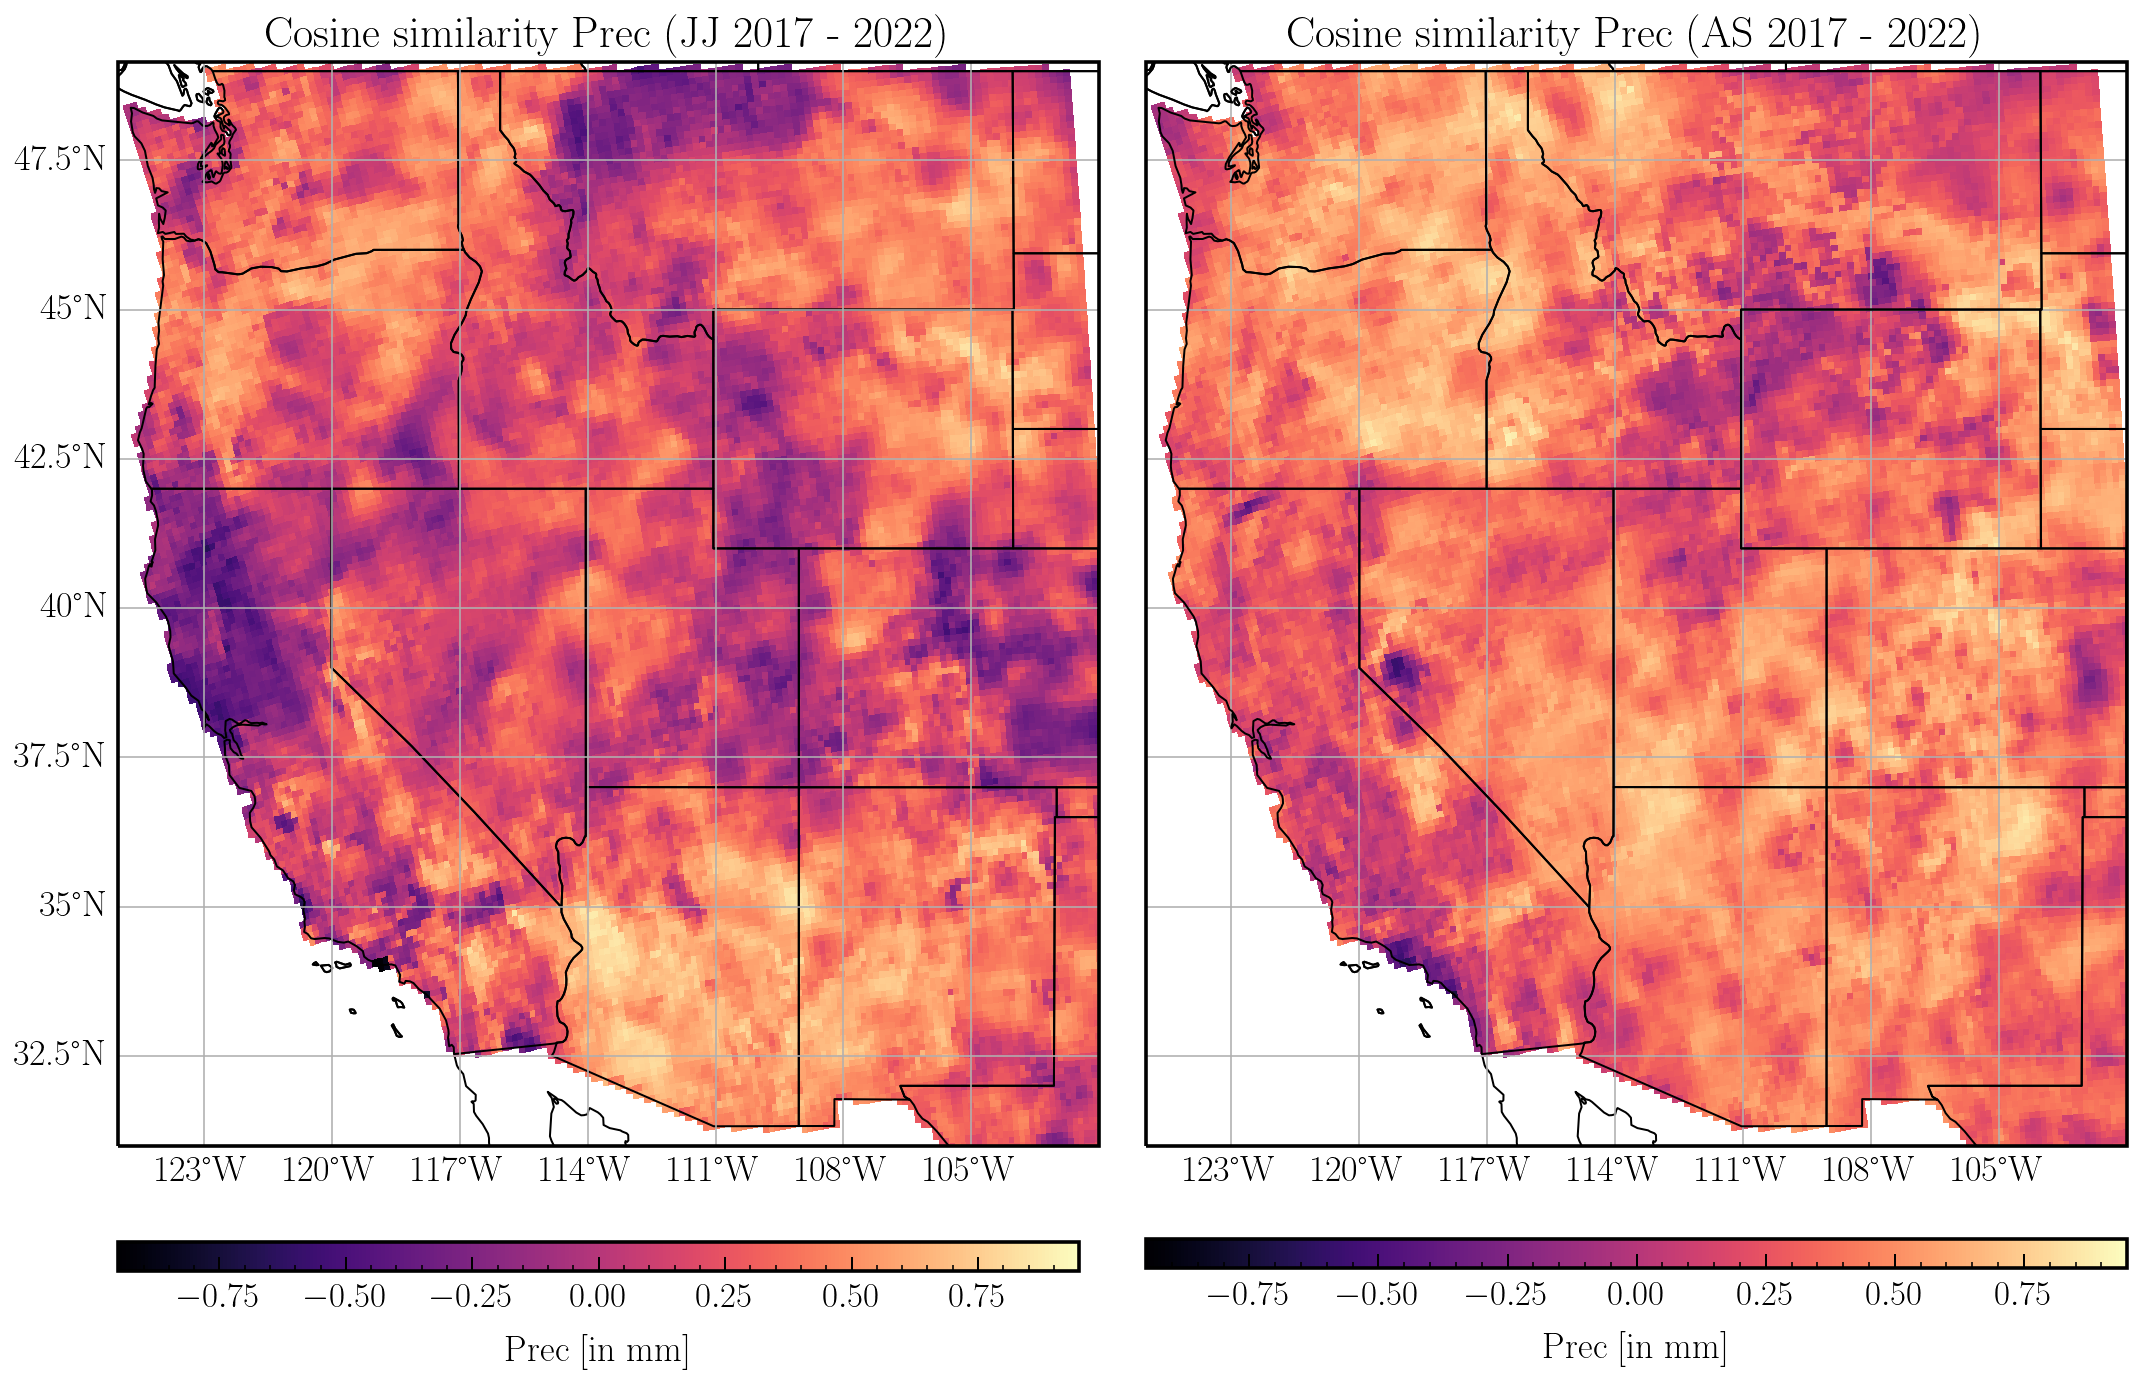

In [16]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], cos_sim_jj_xarr, vmin= -0.95, vmax= 0.95, cmap=plt.cm.magma) 
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
cbar.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Cosine similarity %s (JJ 2017 - 2022)'%pred_var, fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS0= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], cos_sim_as_xarr, vmin= -0.95, vmax= 0.95, cmap=plt.cm.magma) 
cax0= fig.add_axes([ax0.get_position().x0,ax0.get_position().y0 - 0.085, ax0.get_position().width, 0.02])
cbar0= fig.colorbar(CS0, cax= cax0, orientation= 'horizontal', shrink= 0.7)
cbar0.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)
ax0.set_title(r'Cosine similarity %s (AS 2017 - 2022)'%pred_var, fontsize= 22);
plt.savefig('../plots/%s'%pred_var + '_cosine_sim_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 200);

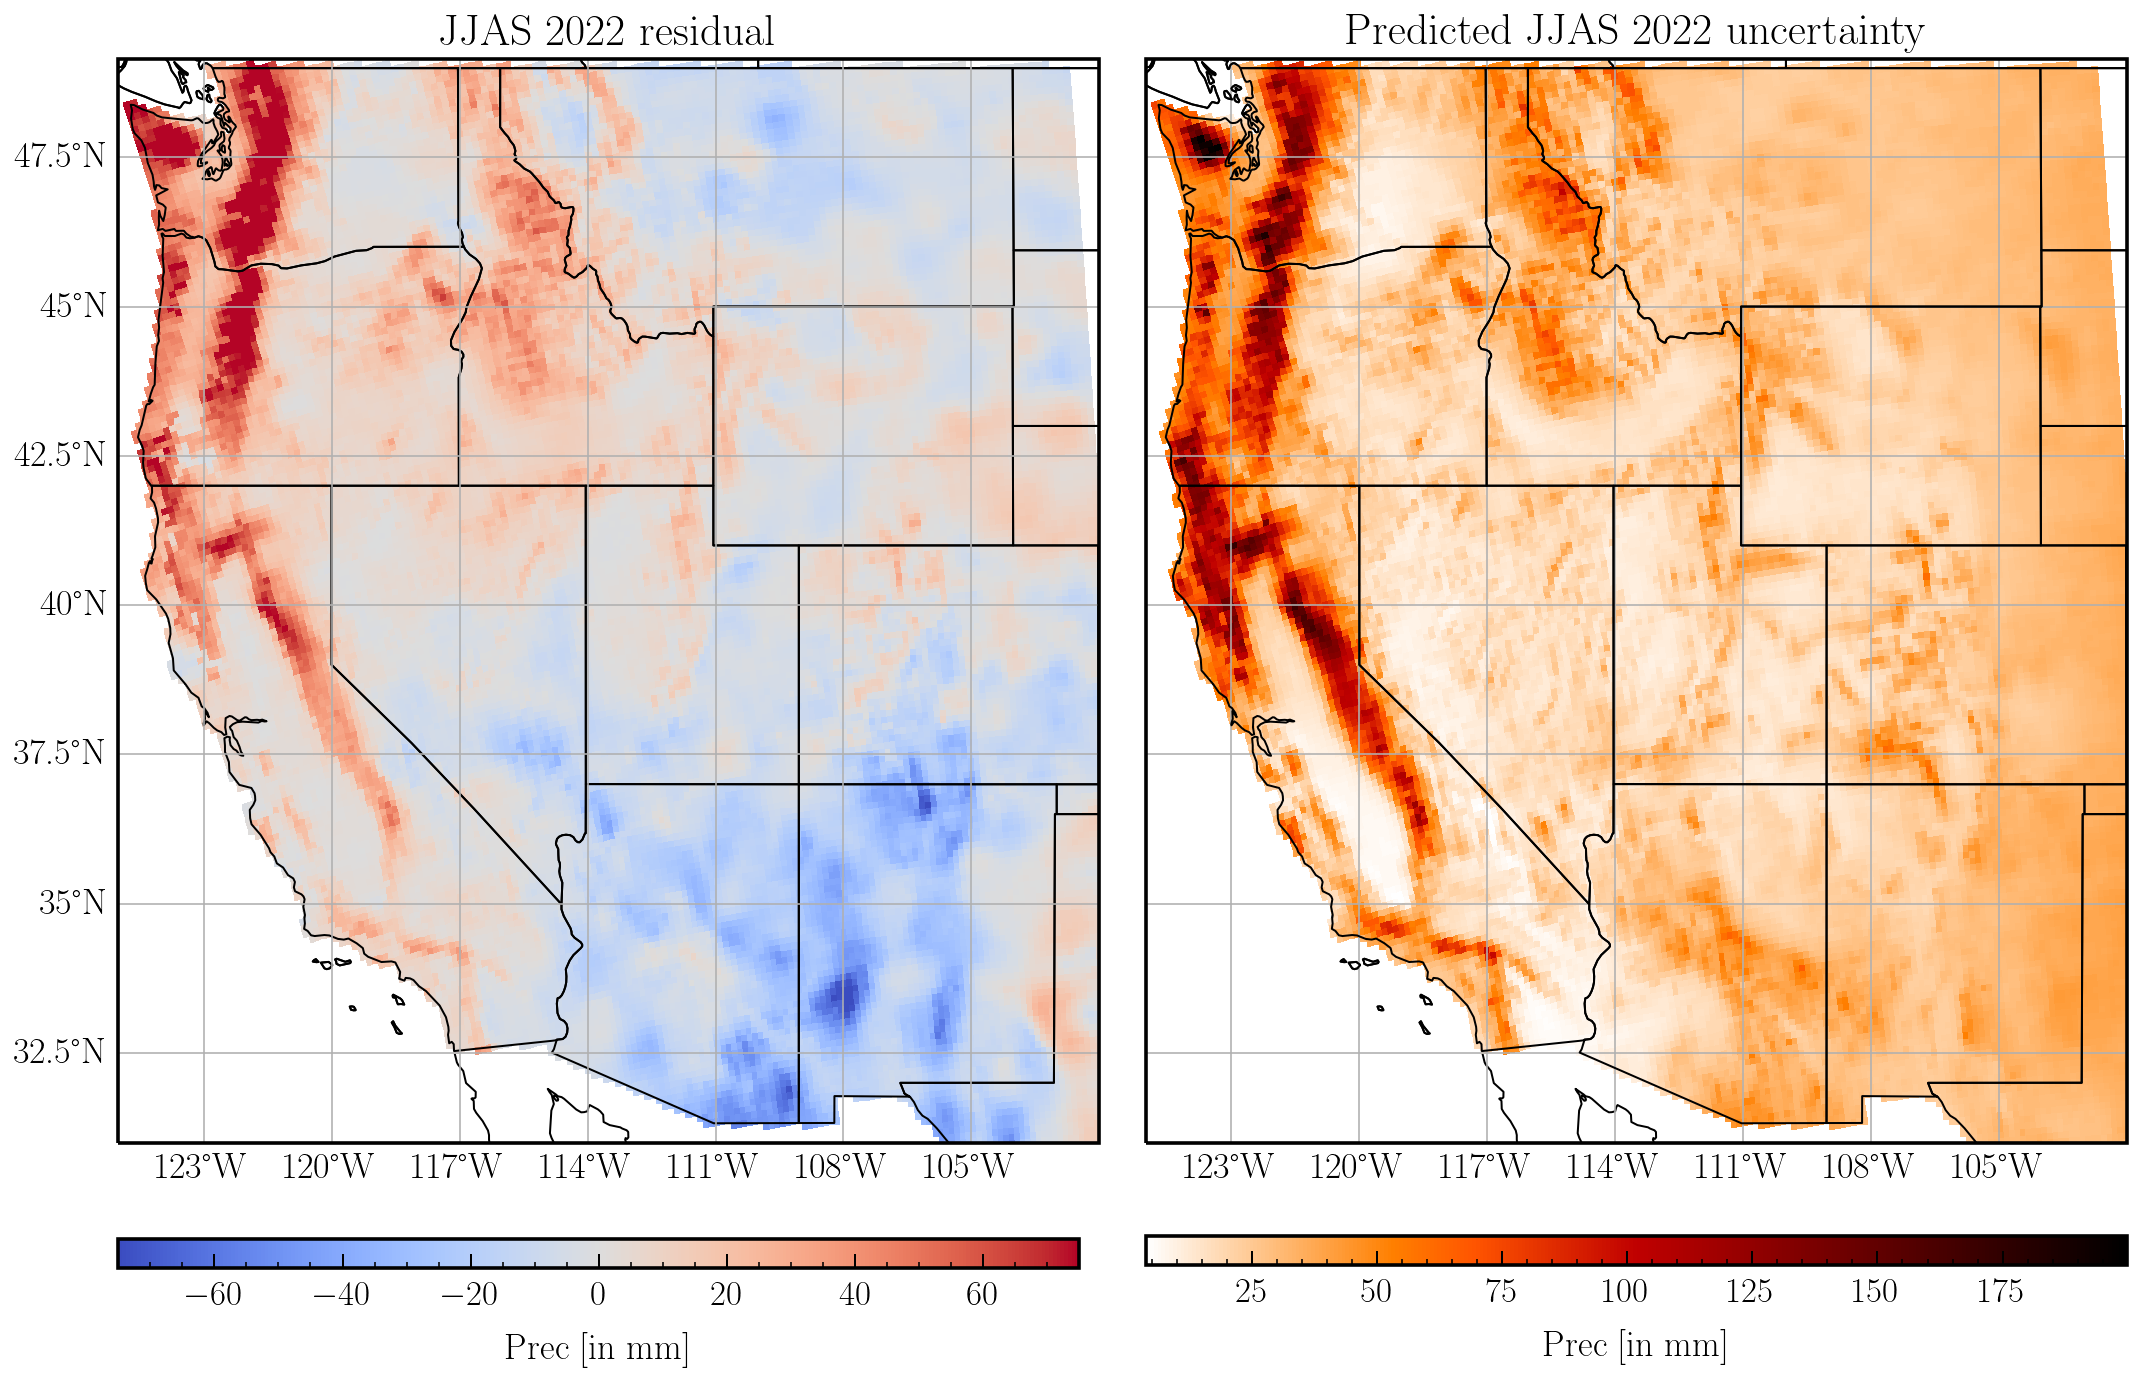

In [20]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_loc_xr[-4:, :, :], axis= 0) - np.mean(Y_obs_xr[-4:, :, :], axis= 0), vmin= -75, vmax= 75, cmap=plt.cm.coolwarm) # normalized fire probability summed over all months
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)
cbar.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'JJAS 2022 residual', fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS0= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], np.mean(Y_dist_scale_xr[-4:, :, :], axis= 0), cmap=plt.cm.gist_heat_r) # normalized fire probability summed over all months
cax0= fig.add_axes([ax0.get_position().x0,ax0.get_position().y0 - 0.085, ax0.get_position().width, 0.02])
cbar0= fig.colorbar(CS0, cax= cax0, orientation= 'horizontal', shrink= 0.7)
cbar0.set_label(r'%s '%pred_var + '[in  %s]'%unit_arr[pred_var], size= 18)
ax0.set_title(r'Predicted JJAS 2022 uncertainty', fontsize= 22);
plt.savefig('../plots/%s'%pred_var + '_spatial_residual_wus_%s.pdf'%run_id, bbox_inches='tight', dpi= 200);

### Feature importance

In [54]:
pred_var= 'FFWI'
run_id= 'grid_normalized_lead2mo'
mb_frac= 0.1

X_features= pd.concat([lead1mons_df[pred_arr_dynamic[pred_var]], lead1mons_df[['Southness', 'Elev', 'nino34', 'mei', 'rmm1', 'rmm2']]], axis= 1).replace(np.nan, 0)
ngb_path= 'ngb_%s'%pred_var + '_%s'%run_id + '_mb_%.2f.p'%(mb_frac)
file_path = Path.home()/'Desktop/seasonal_fire_pred/sav_files/ngb_mods'/ngb_path
with file_path.open("rb") as f:
    ngb= pickle.load(f)

## Feature importance for loc and scale trees
feature_importance_loc = ngb.feature_importances_[0]
feature_importance_scale = ngb.feature_importances_[1]

df_loc = pd.DataFrame({'feature':X_features.columns.values, 'importance':feature_importance_loc[1:]}).sort_values('importance')
df_scale = pd.DataFrame({'feature':X_features.columns.values, 'importance':feature_importance_scale[1:]}).sort_values('importance')

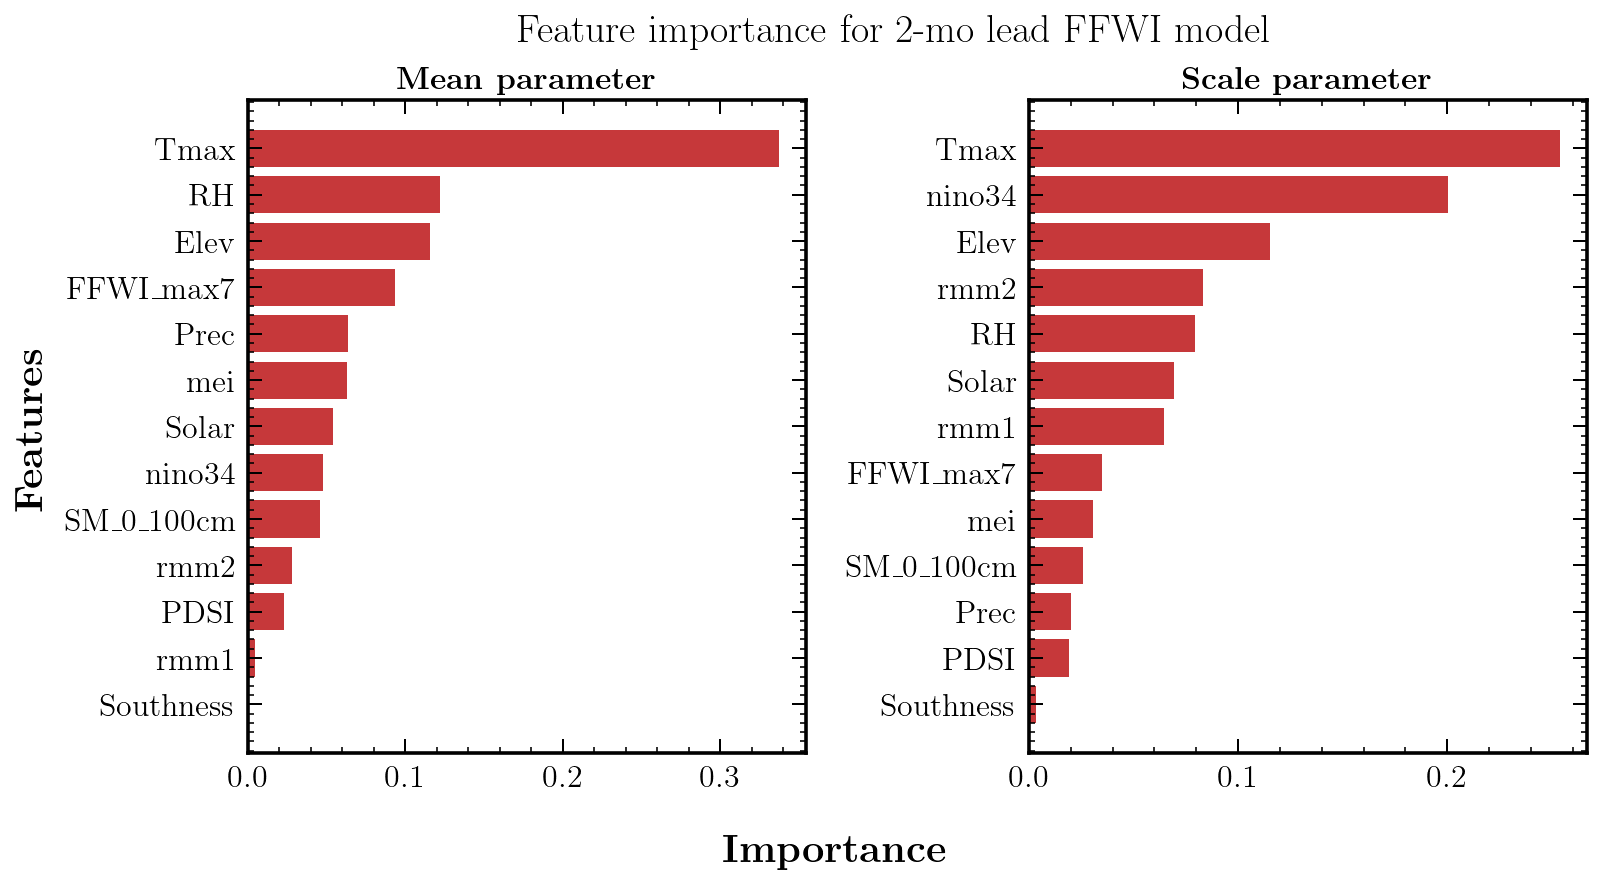

In [55]:
fig, ax= plt.subplots(1, 2, figsize= (12, 6))
fig.text(-0.01, 0.5, r'{\bf Features}', va='center', rotation= 'vertical', fontsize= 20);
fig.text(0.4, 0.01, r'{\bf Importance}', va='center', fontsize= 20);

ax[0].barh(df_loc['feature'], df_loc['importance']) #.loc[X_plot_df.groupby('reg_indx').get_group(regindx).index]
ax[0].set_title(r'{\bf Mean parameter}', va='center', fontsize= 16, pad= 10);
ax[0].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 16);

fig.subplots_adjust(wspace= 0.4)

ax[1].barh(df_scale['feature'], df_scale['importance']) #.loc[X_plot_df.groupby('reg_indx').get_group(regindx).index]
ax[1].set_title(r'{\bf Scale parameter}', va='center', fontsize= 16, pad= 10);
ax[1].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 16);
plt.suptitle(r'Feature importance for 2-mo lead %s model'%pred_var, fontsize= 20);
plt.savefig('../plots/feature_importance/%s'%pred_var + '_feature_importance_%s.pdf'%run_id, bbox_inches='tight', dpi= 300);

### 2023 climate forecasts

In [ ]:
# update saved xarrays with 2023 predictions

## Spatial maps of fire probability and sizes

In [2]:
# load in data frame with observed climate, vegetation, and human predictors

clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_data.h5') 
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

In [3]:
pred_var_arr= ['Tmax', 'Prec',  'VPD', 'FFWI', 'Tmin'] 
run_id_arr= ['grid_normalized_lead1mo', 'grid_normalized_lead2mo', 'grid_normalized_lead3mo']
mb_frac= '0.1'
pred_mon_arr= [461, 462, 463]
pred_tot_loc_df= pd.DataFrame([])
pred_tot_scale_df= pd.DataFrame([])

for pred_var in tqdm(pred_var_arr):
    mon_ind= 0
    pred_var_loc_df= pd.DataFrame([])
    pred_var_scale_df= pd.DataFrame([])
    for run_id in run_id_arr:
        pred_loc_xarr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_loc.nc'%run_id)
        pred_scale_xarr= xarray.open_dataarray('../sav_files/ngb_pred_files/%s'%pred_var + '_%s'%mb_frac + '_%s_ngb_scale.nc'%run_id)
        pred_var_loc_df= pd.concat([pred_var_loc_df, pred_loc_xarr[-4+mon_ind, :, :].to_dataframe(pred_var).reset_index()], ignore_index= True)
        pred_var_scale_df= pd.concat([pred_var_scale_df, pred_scale_xarr[-4+mon_ind, :, :].to_dataframe(pred_var).reset_index()], ignore_index= True)
        mon_ind+= 1
    
    pred_tot_loc_df= pd.concat([pred_tot_loc_df, pred_var_loc_df], axis= 1).drop(columns= ['X', 'Y'])
    pred_tot_scale_df= pd.concat([pred_tot_scale_df, pred_var_scale_df], axis= 1).drop(columns= ['X', 'Y'])

pred_tot_loc_df= pred_tot_loc_df.T.drop_duplicates().T
pred_tot_loc_df.rename(columns= {'FFWI': 'FFWI_max7'}, inplace= True) # rename 'FFWI' to 'FFWI_max7' in pred_tot_loc_df
pred_tot_scale_df= pred_tot_scale_df.T.drop_duplicates().T
pred_tot_scale_df.rename(columns= {'FFWI': 'FFWI_max7'}, inplace= True) # rename 'FFWI' to 'FFWI_max7' in pred_tot_scale_df
pred_tot_loc_df['month']= clim_df[clim_df.month.isin(pred_mon_arr)].month.values
pred_tot_scale_df['month']= clim_df[clim_df.month.isin(pred_mon_arr)].month.values

X_pred_ur_df= pd.concat([clim_df[clim_df.month.isin(pred_mon_arr)].drop(columns= ['Tmax', 'Prec',  'VPD', 'FFWI_max7', 'Tmin']).reset_index(drop= True), pred_tot_loc_df], axis= 1).drop(columns= ['time'])
X_pred_df= X_pred_ur_df[clim_df.columns].dropna().reset_index(drop= True)
X_pred_df= X_pred_df.T.drop_duplicates().T


100%|██████████| 5/5 [00:00<00:00, 39.03it/s]


In [4]:
n_features= 43 # for df with 2021-2022 data 
start_month= 432
tot_test_months= 36
end_month= start_month + tot_test_months
rseed= np.random.randint(1000)

clim_df= clim_df.dropna().reset_index().drop(columns=['index'])
fire_freq_test_ur_df= clim_df[(clim_df.month >= start_month) & (clim_df.month < end_month)]
fire_freq_train_ur_df= clim_df.drop(fire_freq_test_ur_df.index)

tmp_freq_df= X_pred_df[X_pred_df.iloc[:, 0:n_features].columns] 
X_pred_test_df= pd.DataFrame({})
scaler= StandardScaler().fit(fire_freq_train_ur_df.iloc[:, 0:n_features])
X_pred_test_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df)

X_pred_test_df.loc[:, 'reg_indx']= X_pred_df.reg_indx
X_pred_test_df.loc[:, 'month']= X_pred_df.month
X_pred_test_df= X_pred_test_df.drop(columns=['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max3', 'Avgprec_4mo', 'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', \
                                                     'Tmax_max7', 'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness'])

In [5]:
freq_id= '05_22_23'
seed= 1405
mdn_zipd= tf.keras.models.load_model('../sav_files/fire_freq_mods/mdn_ds_%s'%freq_id + '_%s'%seed, custom_objects= {'zipd_loss': zipd_loss, 'zipd_accuracy': zipd_accuracy})
mdn_freq_df= grid_freq_predict(X_test_dat= X_pred_test_df, freq_test_df= X_pred_df, n_regs= 18, ml_model= mdn_zipd, start_month= pred_mon_arr[0], final_month= pred_mon_arr[-1] + 1, func_flag= 'zipd', rseed= 87)
mdn_freq_df.to_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_ds_mon_fire_freq_%s.h5'%freq_id, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 395us/step
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-06-22 13:33:11.593001: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 0s 371us/step


  6%|▌         | 1/18 [00:00<00:04,  3.45it/s]

10/10 [==============================] - 0s 416us/step


 11%|█         | 2/18 [00:00<00:03,  4.33it/s]

17/17 [==============================] - 0s 332us/step


 17%|█▋        | 3/18 [00:00<00:03,  4.56it/s]

8/8 [==============================] - 0s 394us/step


 22%|██▏       | 4/18 [00:00<00:02,  4.92it/s]

37/37 [==============================] - 0s 273us/step


 28%|██▊       | 5/18 [00:01<00:02,  4.63it/s]

19/19 [==============================] - 0s 283us/step


 33%|███▎      | 6/18 [00:01<00:02,  4.78it/s]

22/22 [==============================] - 0s 293us/step


 39%|███▉      | 7/18 [00:01<00:02,  4.79it/s]

65/65 [==============================] - 0s 270us/step


 44%|████▍     | 8/18 [00:01<00:02,  4.24it/s]

42/42 [==============================] - 0s 264us/step


 50%|█████     | 9/18 [00:02<00:02,  4.16it/s]

54/54 [==============================] - 0s 244us/step


 56%|█████▌    | 10/18 [00:02<00:01,  4.02it/s]

33/33 [==============================] - 0s 274us/step


 61%|██████    | 11/18 [00:02<00:01,  4.12it/s]

71/71 [==============================] - 0s 253us/step


 67%|██████▋   | 12/18 [00:02<00:01,  3.83it/s]

68/68 [==============================] - 0s 260us/step


 72%|███████▏  | 13/18 [00:03<00:01,  3.69it/s]

65/65 [==============================] - 0s 254us/step


 78%|███████▊  | 14/18 [00:03<00:01,  3.26it/s]

51/51 [==============================] - 0s 265us/step


 83%|████████▎ | 15/18 [00:03<00:00,  3.38it/s]

62/62 [==============================] - 0s 261us/step


 89%|████████▉ | 16/18 [00:04<00:00,  3.41it/s]

29/29 [==============================] - 0s 275us/step


 94%|█████████▍| 17/18 [00:04<00:00,  3.67it/s]

36/36 [==============================] - 0s 277us/step


100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


In [6]:
mdn_unscaled_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ds_mon_fire_freq_05_22_23.h5')
mdn_mon_freq_df, mdn_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_unscaled_df, n_regs= 18, tot_months= 468, test_start= 432, test_tot= 36, ml_model= 'mdn')
freq_scale_fac= np.nan_to_num(mdn_mon_freq_df[mdn_mon_freq_df.index.isin(pred_mon_arr)]['pred_mean_freq']/mdn_unscaled_df[mdn_unscaled_df.index.isin(pred_mon_arr)]['pred_mean_freq'])

mdn_freq_df['pred_mean_freq']= np.floor(mdn_freq_df['pred_mean_freq']*freq_scale_fac)
mdn_freq_df['pred_high_2sig']= np.floor(mdn_freq_df['pred_high_2sig']*freq_scale_fac)
mdn_freq_df['pred_low_2sig']= np.floor(mdn_freq_df['pred_low_2sig']*freq_scale_fac)

In [7]:
freq_loc_df= grid_freq_loc_predict(X_test_dat= X_pred_test_df, n_regs= 18, ml_model= mdn_zipd, start_month= pred_mon_arr[0], final_month= pred_mon_arr[-1] + 1, rseed= 99) # df of predicted frequency locations averaged over 1000 samples
freq_loc_df.to_hdf('../sav_files/fire_freq_pred_dfs/freq_ssf_ds_loc_df_%s.h5'%freq_id, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

19/19 [==============================] - 0s 359us/step


  6%|▌         | 1/18 [00:00<00:04,  3.50it/s]

10/10 [==============================] - 0s 355us/step


 11%|█         | 2/18 [00:00<00:03,  4.43it/s]

17/17 [==============================] - 0s 287us/step


 17%|█▋        | 3/18 [00:00<00:03,  4.15it/s]

8/8 [==============================] - 0s 462us/step


 22%|██▏       | 4/18 [00:00<00:02,  4.75it/s]

37/37 [==============================] - 0s 285us/step


 28%|██▊       | 5/18 [00:01<00:03,  3.25it/s]

19/19 [==============================] - 0s 309us/step


 33%|███▎      | 6/18 [00:01<00:03,  3.40it/s]

22/22 [==============================] - 0s 274us/step


 39%|███▉      | 7/18 [00:01<00:03,  3.33it/s]

65/65 [==============================] - 0s 276us/step


 44%|████▍     | 8/18 [00:02<00:04,  2.20it/s]

42/42 [==============================] - 0s 268us/step


 50%|█████     | 9/18 [00:03<00:04,  2.08it/s]

54/54 [==============================] - 0s 272us/step


 56%|█████▌    | 10/18 [00:03<00:04,  1.88it/s]

33/33 [==============================] - 0s 266us/step


 61%|██████    | 11/18 [00:04<00:03,  2.01it/s]

71/71 [==============================] - 0s 248us/step


 67%|██████▋   | 12/18 [00:05<00:03,  1.68it/s]

68/68 [==============================] - 0s 282us/step


 72%|███████▏  | 13/18 [00:05<00:03,  1.50it/s]

65/65 [==============================] - 0s 282us/step


 78%|███████▊  | 14/18 [00:06<00:02,  1.39it/s]

51/51 [==============================] - 0s 256us/step


 83%|████████▎ | 15/18 [00:07<00:02,  1.44it/s]

62/62 [==============================] - 0s 262us/step


 89%|████████▉ | 16/18 [00:08<00:01,  1.42it/s]

29/29 [==============================] - 0s 277us/step


 94%|█████████▍| 17/18 [00:08<00:00,  1.64it/s]

36/36 [==============================] - 0s 286us/step


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


In [8]:
pred_loc_arr= loc_ind_func(freq_loc_df, mdn_mon_freq_df, X_pred_test_df, n_regs= 18, start_month= pred_mon_arr[0], final_month= pred_mon_arr[-1] + 1)
pd.DataFrame({'pred_loc': pred_loc_arr}).to_hdf('../sav_files/pred_ssf_loc_df_%s.h5'%freq_id, key= 'df', mode= 'w')

100%|██████████| 18/18 [00:00<00:00, 116.19it/s]


In [21]:
X_pred_ur_df['pred_fire_freq']= np.zeros_like(X_pred_ur_df['fire_freq'])
for r in tqdm(range(18)):
    X_pred_ur_df.loc[X_pred_ur_df.groupby('reg_indx').get_group(r+1).index, 'pred_fire_freq']= 0

for ind in tqdm(np.hstack(pred_loc_arr)):
    X_pred_ur_df.loc[ind, 'pred_fire_freq']+=1

nan_ind_arr= X_pred_ur_df['Tmax'].isna()
X_pred_ur_df.loc[nan_ind_arr, 'pred_fire_freq']= np.nan

100%|██████████| 359/359 [00:00<00:00, 10003.29it/s]


In [22]:
pred_freq_xarr= xarray.DataArray(data= X_pred_ur_df['pred_fire_freq'].to_numpy().reshape(3, 208, 155),
        dims=["month", "Y", "X"],
        coords=dict(
            X=(["X"], np.linspace(-2349250, -501250, 155)),
            Y=(["Y"], np.linspace(3166500, 682500, 208)),
            time= (["month"], np.linspace(0, 2, 3, dtype= np.int64)),),)
lat_long_fire_grid= coord_transform(pred_freq_xarr['X'][:].data, pred_freq_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

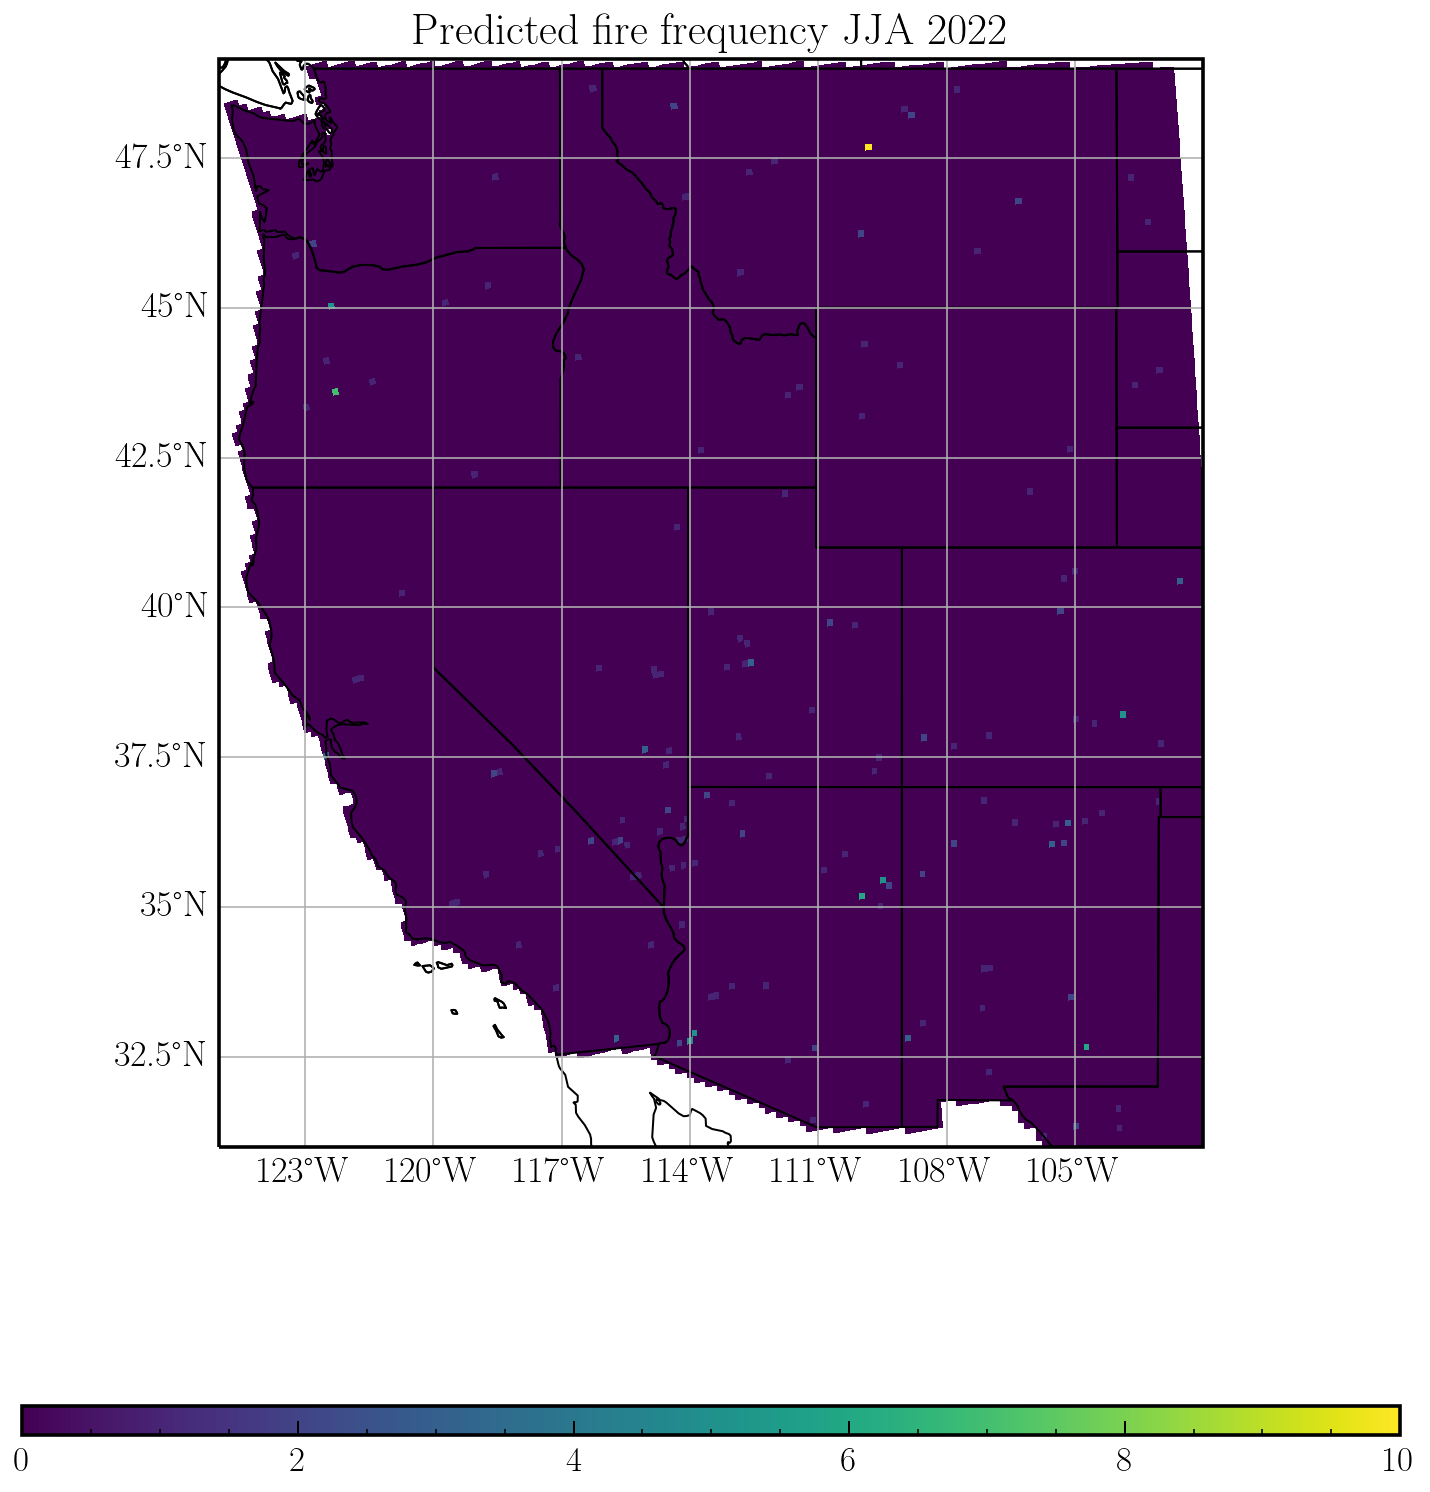

In [23]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

CS= ax.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], pred_freq_xarr.sum(axis= 0, skipna= False), cmap=plt.cm.viridis) 
cax= fig.add_axes([ax.get_position().x0,ax.get_position().y0 - 0.2, ax.get_position().width, 0.02])
cbar= fig.colorbar(CS, cax= cax, orientation= 'horizontal', shrink= 0.7)

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'Predicted fire frequency JJA 2022', fontsize= 22);